In [5]:
#1. CARGAR LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
import shap

In [142]:
#2. CARGAR DATOS
df = pd.read_csv('taller2_MLE.csv')

In [143]:
# Limpia espacios, acentos y mayúsculas
df['rango_ingresos'] = df['rango_ingresos'].str.strip().str.replace(" ", "_").str.lower()

In [171]:
# Convertir 'segmento' en una variable categórica con un orden específico
df['segmento'] = pd.Categorical(df['segmento'], 
                                categories=['Premium', 'Preferente', 'Estándar'], 
                                ordered=True)

In [145]:
df['cerrara_cuenta'].value_counts()

cerrara_cuenta
0    4298
1     702
Name: count, dtype: int64

In [146]:
df.head()

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,medio,Sierra,0
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,muy_alto,Selva,0
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,medio,Sierra,1
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,bajo,Selva,0
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,medio,Sierra,0


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   edad                   5000 non-null   int64   
 1   segmento               5000 non-null   category
 2   saldo_total            5000 non-null   float64 
 3   numero_productos       5000 non-null   int64   
 4   visitas_app_mes        5000 non-null   int64   
 5   usa_web                5000 non-null   int64   
 6   usa_tarjeta_credito    5000 non-null   int64   
 7   reclamos_6m            5000 non-null   int64   
 8   satisfaccion_encuesta  5000 non-null   float64 
 9   tasa_credito_personal  5000 non-null   float64 
 10  rango_ingresos         5000 non-null   object  
 11  region                 5000 non-null   object  
 12  cerrara_cuenta         5000 non-null   int64   
dtypes: category(1), float64(3), int64(7), object(2)
memory usage: 473.9+ KB


In [148]:
import pandas as pd
import numpy as np

# ===============================
# Variables de comportamiento
# ===============================


# Interacción media con la app (log-transformación para normalizar)
df["log_visitas_app"] = np.log1p(df["visitas_app_mes"])

# ===============================
# 3Variables de riesgo
# ===============================

# Riesgo por tasa alta (clientes con tasas altas tienden a irse)
df["riesgo_tasa"] = np.where(df["tasa_credito_personal"] > df["tasa_credito_personal"].median(), 1, 0)

# Clientes con reclamos recientes + baja satisfacción
df["riesgo_insatisfaccion"] = np.where(
    (df["reclamos_6m"] > 0) & (df["satisfaccion_encuesta"] < 3), 1, 0
)

# ===============================
# Variables demográficas / económicas
# ===============================

# Clasificación por edad
df["grupo_edad"] = pd.cut(
    df["edad"],
    bins=[0, 30, 45, 60, 120],
    labels=["Joven", "Adulto_Joven", "Adulto", "Senior"]
)

# ===============================
# Interacciones lógicas / mixtas
# ===============================

# Clientes “silenciosos”: no reclaman, no usan web, baja satisfacción
df["cliente_silencioso"] = np.where(
    (df["reclamos_6m"] == 0)
    & (df["usa_web"] == 0)
    & (df["satisfaccion_encuesta"] <= 3),
    1,
    0
)


# ===============================
# 7️⃣ Normalización logarítmica
# ===============================

df["log_saldo_total"] = np.log1p(df["saldo_total"])

# ===============================
# ✅ Resultado final
# ===============================

df.head()


,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta,log_visitas_app,riesgo_tasa,riesgo_insatisfaccion,grupo_edad,cliente_silencioso,log_saldo_total
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,medio,Sierra,0,2.484907,1,0,Adulto,0,10.687225
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,muy_alto,Selva,0,2.079442,1,0,Adulto_Joven,1,9.794892
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,medio,Sierra,1,1.386294,0,1,Adulto,0,9.138747
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,bajo,Selva,0,1.791759,1,0,Joven,0,6.566335
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,medio,Sierra,0,1.609438,1,0,Senior,0,9.926836


In [149]:
# Seleccionamos solo columnas numéricas
corr_matrix = df.select_dtypes(include='number').corr()

# Mostramos la matriz
display(corr_matrix)

,edad,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,cerrara_cuenta,log_visitas_app,riesgo_tasa,riesgo_insatisfaccion,cliente_silencioso,log_saldo_total
edad,1.000000,0.010770,0.002545,-0.015753,-0.006952,-0.030663,0.009955,-0.005724,-0.023122,0.008659,-0.016339,-0.034268,0.005091,0.023603,-0.004561
saldo_total,0.010770,1.000000,0.024975,-0.010541,0.019118,-0.003453,0.006707,-0.005202,-0.010410,-0.033003,-0.000568,-0.008811,0.006040,-0.013404,0.664932
numero_productos,0.002545,0.024975,1.000000,-0.015766,0.014316,-0.001631,0.013031,0.007080,-0.009806,-0.039085,-0.013619,-0.009441,-0.000917,-0.016236,0.024018
visitas_app_mes,-0.015753,-0.010541,-0.015766,1.000000,-0.003206,-0.010397,-0.008381,-0.022572,0.008622,0.012285,0.958149,-0.003125,0.010075,0.020219,0.010908
usa_web,-0.006952,0.019118,0.014316,-0.003206,1.000000,0.006857,-0.016218,0.009381,0.035093,-0.004641,-0.008585,0.042641,0.000713,-0.498886,-0.008692
usa_tarjeta_credito,-0.030663,-0.003453,-0.001631,-0.010397,0.006857,1.000000,0.010948,-0.026639,0.001813,0.022564,-0.008123,0.004290,0.033589,-0.003334,0.003131
reclamos_6m,0.009955,0.006707,0.013031,-0.008381,-0.016218,0.010948,1.000000,-0.011986,-0.020230,0.024427,-0.006433,-0.029992,0.533548,-0.228537,0.008123
satisfaccion_encuesta,-0.005724,-0.005202,0.007080,-0.022572,0.009381,-0.026639,-0.011986,1.000000,-0.013439,-0.139740,-0.024832,-0.019852,-0.436556,-0.262195,-0.004672
tasa_credito_personal,-0.023122,-0.010410,-0.009806,0.008622,0.035093,0.001813,-0.020230,-0.013439,1.000000,-0.019942,0.001524,0.799052,-0.001852,-0.007394,-0.005688
cerrara_cuenta,0.008659,-0.033003,-0.039085,0.012285,-0.004641,0.022564,0.024427,-0.139740,-0.019942,1.000000,0.009947,-0.015796,0.075420,0.046819,-0.047021


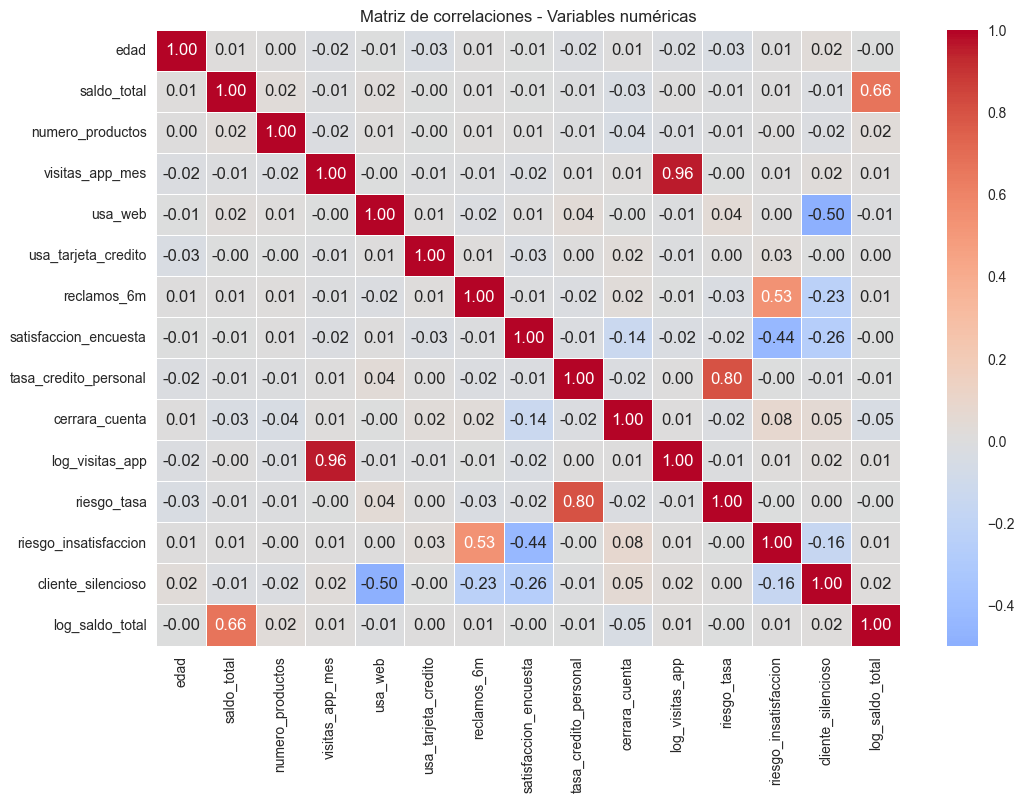

In [150]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,       # Muestra los valores
    fmt=".2f",        # Formato de decimales
    cmap="coolwarm",  # Paleta de colores
    center=0, 
    linewidths=0.5
)
plt.title("Matriz de correlaciones - Variables numéricas")
plt.show()

No hay variables lo suficientemente predictoras por lo que se tendrá a criterio de negocio crear variables.

In [151]:
df.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9,.91,.92,.93,.94, .95]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,91%,92%,93%,94%,95%,max
edad,5000.0,46.141000,16.357733,18.0,23.900000,29.000000,35.000000,41.000000,46.000000,52.000000,57.000000,63.000000,69.000000,69.000000,70.000000,70.000000,71.000000,72.000000,74.000000
saldo_total,5000.0,20416.034312,13588.538852,0.0,819.952000,7325.520000,12225.952000,16113.056000,19784.830000,23578.920000,27584.876000,32460.090000,38518.290000,39526.735200,40403.736400,41579.431900,42670.481200,43833.220500,66416.670000
numero_productos,5000.0,2.987800,1.420583,1.0,1.000000,1.000000,2.000000,3.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
visitas_app_mes,5000.0,6.047000,2.484195,0.0,3.000000,4.000000,5.000000,5.000000,6.000000,6.000000,7.000000,8.000000,9.000000,9.000000,10.000000,10.000000,10.000000,10.000000,17.000000
usa_web,5000.0,0.699000,0.458739,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
usa_tarjeta_credito,5000.0,0.612400,0.487251,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
reclamos_6m,5000.0,0.489000,0.700555,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,6.000000
satisfaccion_encuesta,5000.0,3.018240,1.145849,1.0,1.400000,1.800000,2.200000,2.600000,3.000000,3.400000,3.800000,4.200000,4.600000,4.600000,4.700000,4.700000,4.800000,4.800000,5.000000
tasa_credito_personal,5000.0,34.986158,8.156743,10.0,24.390000,28.286000,30.730000,32.970000,35.120000,37.094000,39.340000,41.840000,45.440000,45.950000,46.460000,46.950700,47.550600,48.240500,65.040000
cerrara_cuenta,5000.0,0.140400,0.347436,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [152]:
df.shape

(5000, 19)

In [153]:
df.columns

Index(['edad', 'segmento', 'saldo_total', 'numero_productos',
       'visitas_app_mes', 'usa_web', 'usa_tarjeta_credito', 'reclamos_6m',
       'satisfaccion_encuesta', 'tasa_credito_personal', 'rango_ingresos',
       'region', 'cerrara_cuenta', 'log_visitas_app', 'riesgo_tasa',
       'riesgo_insatisfaccion', 'grupo_edad', 'cliente_silencioso',
       'log_saldo_total'],
      dtype='object')

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   edad                   5000 non-null   int64   
 1   segmento               5000 non-null   category
 2   saldo_total            5000 non-null   float64 
 3   numero_productos       5000 non-null   int64   
 4   visitas_app_mes        5000 non-null   int64   
 5   usa_web                5000 non-null   int64   
 6   usa_tarjeta_credito    5000 non-null   int64   
 7   reclamos_6m            5000 non-null   int64   
 8   satisfaccion_encuesta  5000 non-null   float64 
 9   tasa_credito_personal  5000 non-null   float64 
 10  rango_ingresos         5000 non-null   object  
 11  region                 5000 non-null   object  
 12  cerrara_cuenta         5000 non-null   int64   
 13  log_visitas_app        5000 non-null   float64 
 14  riesgo_tasa            5000 non-null   i

In [155]:
clf = setup(
    data=df,
    target='cerrara_cuenta',
    session_id=123,

    # 🔹 Columnas categóricas
    categorical_features=[
        'segmento',
        'usa_web',
        'usa_tarjeta_credito',
        'reclamos_6m',
        'rango_ingresos',
        'grupo_edad',
        'riesgo_tasa',
        'riesgo_insatisfaccion',
        'cliente_silencioso'
    ],
    ignore_features=['region'],

    # 🔹 Escalado y transformación
    normalize=True,
    transformation=True,
    transformation_method='yeo-johnson',

    # 🔹 Multicolinealidad
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,

    # 🔹 Selección automática de variables
    feature_selection=True,
    feature_selection_method='classic',
    n_features_to_select=0.9,

    # 🔹 Balanceo de clases
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',

    # 🔹 Validación cruzada
    fold_strategy='stratifiedkfold',
    fold=10,
    verbose=False
)


In [156]:
# Comparar modelos automáticamente
best_model = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6077,0.5984,0.4887,0.1759,0.2586,0.0662,0.0825,0.9060
ridge,Ridge Classifier,0.6077,0.5987,0.4846,0.1748,0.2568,0.0641,0.0800,0.3700
lda,Linear Discriminant Analysis,0.6077,0.5986,0.4846,0.1748,0.2568,0.0641,0.0800,0.3240
svm,SVM - Linear Kernel,0.6034,0.5673,0.4578,0.1676,0.2428,0.0493,0.0616,0.3670
nb,Naive Bayes,0.6774,0.5822,0.3685,0.1833,0.2443,0.0693,0.0754,0.3390
qda,Quadratic Discriminant Analysis,0.6654,0.5639,0.3523,0.1703,0.2291,0.0488,0.0535,0.3380
knn,K Neighbors Classifier,0.6357,0.5061,0.3378,0.1482,0.2053,0.0139,0.0163,0.6160
dt,Decision Tree Classifier,0.7380,0.5041,0.1791,0.1450,0.1599,0.0068,0.0070,0.3730
lightgbm,Light Gradient Boosting Machine,0.8529,0.5753,0.0224,0.2755,0.0407,0.0176,0.0379,0.4920
et,Extra Trees Classifier,0.8471,0.5474,0.0204,0.1649,0.0361,0.0042,0.0084,0.4280


In [157]:
#CREAR MODELO
model_inicial = create_model('lr')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:46:45
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6371,0.6320,0.5510,0.2045,0.2983,0.1183,0.1447
1,0.5943,0.5581,0.3878,0.1450,0.2111,0.0092,0.0112
2,0.6171,0.6461,0.5510,0.1942,0.2872,0.1012,0.1269
3,0.6229,0.5978,0.4082,0.1626,0.2326,0.0404,0.0479
4,0.5943,0.5883,0.5510,0.1837,0.2755,0.0829,0.1071
5,0.6314,0.5927,0.4898,0.1875,0.2712,0.0861,0.1039
6,0.6029,0.5934,0.5510,0.1875,0.2798,0.0896,0.1145
7,0.5857,0.5428,0.3878,0.1418,0.2077,0.0033,0.0041
8,0.5800,0.5962,0.4694,0.1597,0.2383,0.0372,0.0475


In [158]:
best_model = tune_model(model_inicial, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6371,0.6321,0.5510,0.2045,0.2983,0.1183,0.1447
1,0.5943,0.5581,0.3878,0.1450,0.2111,0.0092,0.0112
2,0.6171,0.6461,0.5510,0.1942,0.2872,0.1012,0.1269
3,0.6200,0.5977,0.4082,0.1613,0.2312,0.0382,0.0454
4,0.5943,0.5884,0.5510,0.1837,0.2755,0.0829,0.1071
5,0.6314,0.5924,0.4898,0.1875,0.2712,0.0861,0.1039
6,0.6029,0.5935,0.5510,0.1875,0.2798,0.0896,0.1145
7,0.5829,0.5430,0.3878,0.1407,0.2065,0.0014,0.0017
8,0.5800,0.5962,0.4694,0.1597,0.2383,0.0372,0.0475


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [159]:
# Obtener los coeficientes del modelo y sus nombres de variable
feature_names = get_config('X_train_transformed').columns
coeficientes = pd.Series(best_model.coef_.ravel(), index=feature_names).sort_values(ascending=False)
print(coeficientes)

rango_ingresos_bajo      0.339470
rango_ingresos_medio     0.313522
riesgo_insatisfaccion    0.290983
segmento_Estándar        0.272338
saldo_total              0.236366
riesgo_tasa              0.070773
visitas_app_mes          0.069093
usa_tarjeta_credito      0.066965
edad                     0.029731
reclamos_6m_1.0          0.009479
tasa_credito_personal   -0.056323
numero_productos        -0.069957
usa_web                 -0.097486
satisfaccion_encuesta   -0.217294
log_saldo_total         -0.369449
dtype: float64


In [160]:
# Evaluar mejor modelo
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

1) ¿Cuál es el % de clientes que cerraron su cuenta? ¿Está balanceado el dataset?

In [161]:
counts = df['cerrara_cuenta'].value_counts()
pct = counts / counts.sum() * 100
pct_formateado = pct.round(2).apply(lambda x: f"{x} %")
print(pct_formateado)

cerrara_cuenta
0    85.96 %
1    14.04 %
Name: count, dtype: object


2) ¿Qué variables tienen mayor correlación con cerrara_cuenta?

In [162]:
# Seleccionamos solo columnas numéricas
corr_matrix = df.select_dtypes(include='number').corr()

corr_matrix['cerrara_cuenta'].abs().sort_values(ascending=False)

cerrara_cuenta           1.000000
satisfaccion_encuesta    0.139740
riesgo_insatisfaccion    0.075420
log_saldo_total          0.047021
cliente_silencioso       0.046819
numero_productos         0.039085
saldo_total              0.033003
reclamos_6m              0.024427
usa_tarjeta_credito      0.022564
tasa_credito_personal    0.019942
riesgo_tasa              0.015796
visitas_app_mes          0.012285
log_visitas_app          0.009947
edad                     0.008659
usa_web                  0.004641
Name: cerrara_cuenta, dtype: float64

In [163]:
# Correlaciones numéricas
corr = df.corr(numeric_only=True)['cerrara_cuenta'].abs().sort_values(ascending=False)
print(corr)

# Importancia vía modelo
print(""*20)
print("*"*20)
print("MODELO")
print("*"*20)
coef = abs(pd.Series(best_model.coef_.ravel(), index=feature_names)).sort_values(ascending=False)
print(coef.head(6))

cerrara_cuenta           1.000000
satisfaccion_encuesta    0.139740
riesgo_insatisfaccion    0.075420
log_saldo_total          0.047021
cliente_silencioso       0.046819
numero_productos         0.039085
saldo_total              0.033003
reclamos_6m              0.024427
usa_tarjeta_credito      0.022564
tasa_credito_personal    0.019942
riesgo_tasa              0.015796
visitas_app_mes          0.012285
log_visitas_app          0.009947
edad                     0.008659
usa_web                  0.004641
Name: cerrara_cuenta, dtype: float64

********************
MODELO
********************
log_saldo_total          0.369449
rango_ingresos_bajo      0.339470
rango_ingresos_medio     0.313522
riesgo_insatisfaccion    0.290983
segmento_Estándar        0.272338
saldo_total              0.236366
dtype: float64


En correlación la que más se correlaciona en satisfacción encuesta

3) ¿Cuál es el mejor modelo en AUC? ¿Y en Recall?

Según el modelo en AUC es Ridge Classifier, Linear Discriminant Analysis, Logistic Regresion
Según el modelo en Recall es SVM - Linear Kernel

4) ¿Qué combinación de variables permite identificar clientes silenciosos que se van (sin reclamos)?

In [164]:
# Clientes “silenciosos”: no reclaman, no usan web, baja satisfacción
df["cliente_silencioso"] = np.where(
    (df["reclamos_6m"] == 0)
    & (df["usa_web"] == 0)
    & (df["satisfaccion_encuesta"] <= 3),
    1,
    0
)

#Reclamos_6, si no ha hecho un reclamo en 6 meses es poco proable que cierre la cuenta, pero puede que tengan una satfisacción baja y terminen cerrando la cuenta.

5) ¿Qué pasa si el modelo predice mal un cliente que no se iba (FP)? ¿Y uno que sí se iba (FN)?

FP (falso positivo): Predice que se va, pero no se iba. Coste = gastos de retención (llamada, oferta económica, tiempo gestor) + posible molestar al cliente.

FN (falso negativo): Predice que no se va, pero se iba. Coste = pérdida del cliente (CLTV futuro), venta cruzada perdida, impacto reputacional.

In [165]:
from sklearn.metrics import confusion_matrix
y_true= get_config('y_test')
y_pred = best_model.predict(get_config('X_test_transformed'))

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
cost_fp = 200  # coste estimado por acción de retención
cost_fn = 20000  # pérdida estimada por cliente premium perdido
expected_cost = fp*cost_fp + fn*cost_fn
print(f"Coste esperado: {expected_cost}")

Coste esperado: 1951600


6) ¿Qué umbral de score (0.5 vs optimizado por KS) usar para reducir pérdida financiera?

KS máximo: 0.2341
Umbral óptimo (por KS): 0.4777


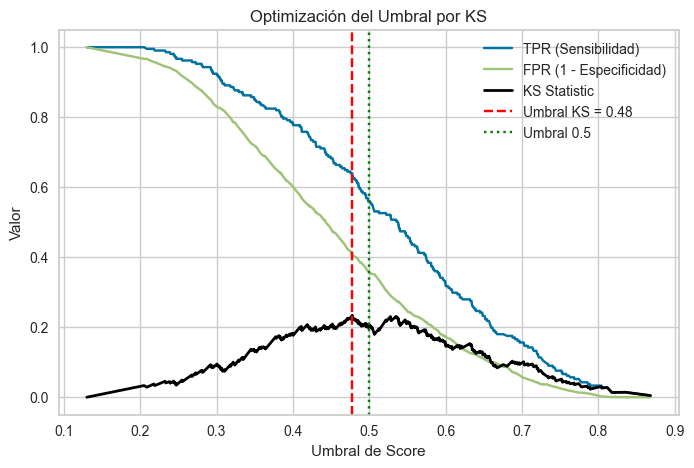

In [166]:
from sklearn.metrics import roc_curve
# Obtener X_test y y_test del entorno PyCaret
X_test = get_config('X_test_transformed')
y_test = get_config('y_test')

# Probabilidades del modelo (clase positiva)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# KS statistic = TPR - FPR
ks_values = tpr - fpr
ks_idx = np.argmax(ks_values)
threshold_ks = thresholds[ks_idx]

print(f"KS máximo: {ks_values[ks_idx]:.4f}")
print(f"Umbral óptimo (por KS): {threshold_ks:.4f}")

plt.figure(figsize=(8,5))
plt.plot(thresholds, tpr, label='TPR (Sensibilidad)')
plt.plot(thresholds, fpr, label='FPR (1 - Especificidad)')
plt.plot(thresholds, ks_values, label='KS Statistic', color='black', linewidth=2)

# Resaltar el punto óptimo
plt.axvline(threshold_ks, color='red', linestyle='--', label=f'Umbral KS = {threshold_ks:.2f}')
plt.axvline(0.5, color='green', linestyle=':', label='Umbral 0.5')

plt.title('Optimización del Umbral por KS')
plt.xlabel('Umbral de Score')
plt.ylabel('Valor')
plt.legend()
plt.show()


El modelo está más sensible (detecta más fugas, pero puede tener más falsos positivos).

7) ¿Cómo explicarías con SHAP que un cliente Premium con buen saldo igual fue predicho como fuga?

In [167]:
df['segmento'].value_counts()

segmento
Estándar      3016
Preferente    1492
Premium        492
Name: count, dtype: int64

In [168]:
get_config('X_test_transformed').columns

Index(['edad', 'segmento_Estándar', 'saldo_total', 'numero_productos',
       'visitas_app_mes', 'usa_web', 'usa_tarjeta_credito', 'reclamos_6m_1.0',
       'satisfaccion_encuesta', 'tasa_credito_personal', 'rango_ingresos_bajo',
       'rango_ingresos_medio', 'riesgo_tasa', 'riesgo_insatisfaccion',
       'log_saldo_total'],
      dtype='object')

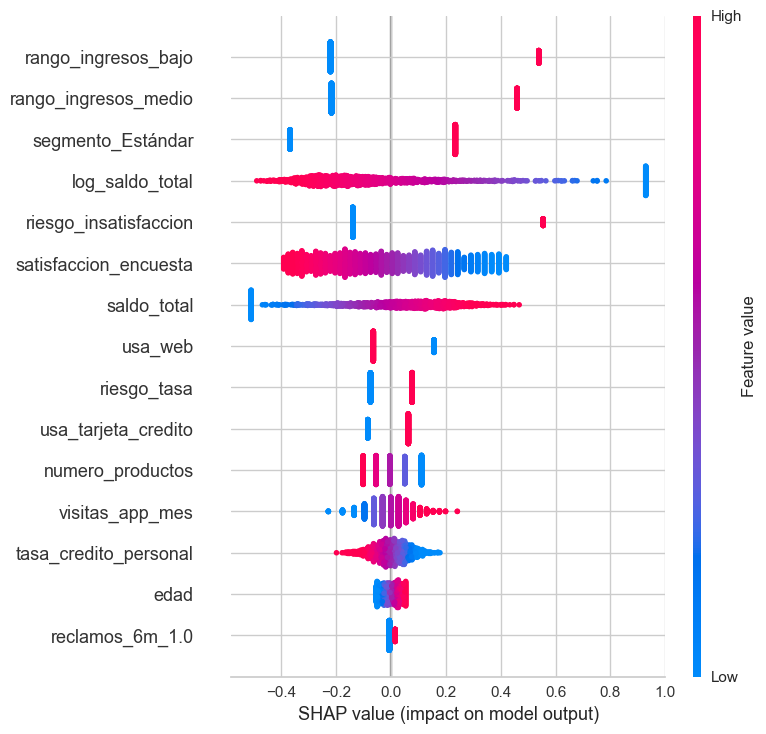

In [169]:
import shap
explainer = shap.Explainer(best_model, get_config('X_test_transformed'))
shap_values = explainer(get_config('X_test_transformed'))
shap.summary_plot(shap_values, get_config('X_test_transformed'))

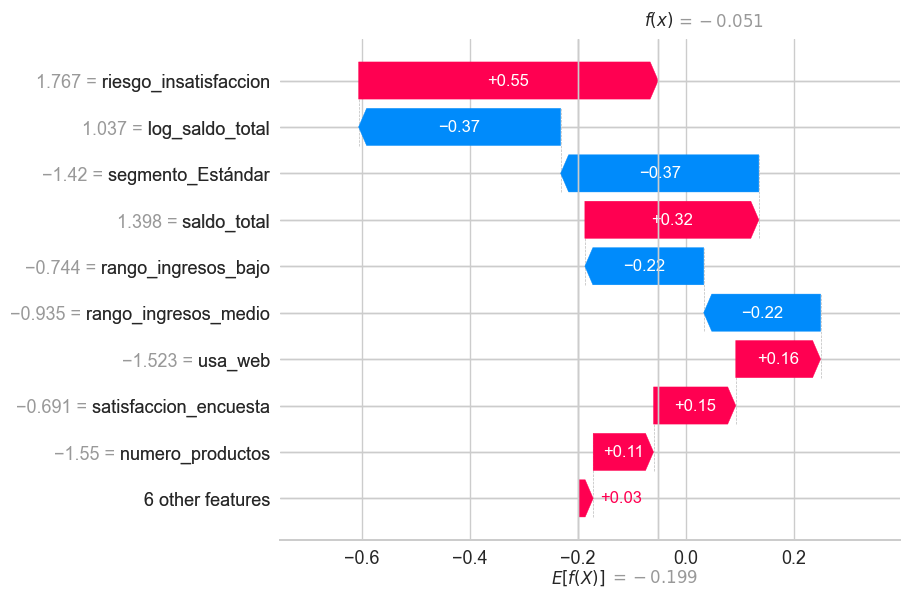

In [173]:
shap.plots.waterfall(shap_values[30])

En este caso, aunque el cliente sea Premium y tenga alto saldo total, los valores SHAP muestran que otras características con mayor peso en la predicción como una baja satisfacción en la encuesta o un alto nivel de reclamos recientes tienen un efecto positivo fuerte sobre la probabilidad de fuga.

8) ¿Debería incluir la tasa de interés ofrecida como predictor, si luego esta puede cambiar según la política?


Podríamos crear dos modelos:
- Operativo: despliegue en producción para scoring normal.

- Simulador (incluye tasa): para evaluar y política de retención (simular reducción de tasa y ver impacto).

9. ¿Cómo usarías este modelo en un sistema de reglas mixtas (modelo + regla de negocio) para que los gestores humanos no pierdan confianza?

Lo usaría como un consultor, ver como las reglas de negocio se comportan con el modelo o sin modelo.
Si deseamos crear el modelo con las reglas de negocio, podríamos crear feactures con el modelo para que puedas aceptar la acción.

La idea de un sistema mixto es combinar la predicción estadística (modelo ML) con la experiencia humana o reglas de negocio, para tomar decisiones más robustas y transparentes.